# STAT 5205/4205 Final Project (Python)
## Global Temperature Anomaly vs Global Mean Sea Level (with Evaporation)

- `Global_TAVG_monthly.txt` (temperature anomaly, monthly)
- `GMSL_TPJAOS_5.2.txt` (GMSL product, monthly)
- `GLEAM_global_monthly_evaporation.csv` (monthly global evaporation)
- CO2

This notebook:

1. Loads temperature anomaly and GMSL, aligns to **calendar months**, and creates a clean monthly panel.
2. Adds **evaporation** (note: your evaporation file starts in 2003, so models that include evaporation will use a shorter sample).
3. Creates **≥ 4 figures**, including a **3D-style** bubble plot (color + size).
4. Fits OLS regressions and reports **Newey–West (HAC, lag=12)** standard errors.

Outputs are saved to:
- Figures: `pic/`
- Tables: `out/`


## 0) Setup and paths

### Edit paths (Windows)
You provided these Windows paths:

- `C:\Users\F\Desktop\5205 final project\GLEAM_global_monthly_evaporation.csv`
- `C:\Users\F\Desktop\5205 final project\GMSL_TPJAOS_5.2.txt`
- `C:\Users\F\Desktop\5205 final project\Global_TAVG_monthly.txt`

In Python, use **raw strings** (prefix with `r"..."`) so backslashes don’t get interpreted as escapes.

This notebook will:
- try your Windows paths first
- if not found, fall back to local filenames in the current folder


In [80]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.stats.sandwich_covariance import cov_hac

TEMP_PATH = "Global_TAVG_monthly.txt"
GMSL_PATH = "GMSL_TPJAOS_5.2.txt"
EVAP_PATH = "GLEAM_global_monthly_evaporation.csv"
CO2_PATH = "co2_mm_mlo.csv"

# Normal CDF helper (for HAC p-values)
try:
    from scipy.stats import norm
    _norm_cdf = norm.cdf
except Exception:
    import math
    def _norm_cdf(x):
        x = np.asarray(x, dtype=float)
        return 0.5 * (1.0 + np.vectorize(math.erf)(x / np.sqrt(2.0)))

## 1) Parsing helper functions

### Monthly join key
We represent each month by the **15th day of that month** (`YYYY-MM-15`) to make merging simple and consistent.

### Temperature file format (Berkeley Earth)
Your temperature file includes many header lines (starting with `%`) and then rows like:

`Year  Month  Monthly_Anomaly  ...`

We only need:
- year
- month
- monthly anomaly

### GMSL file format (NASA GSFC / PO.DAAC v5.2)
The header describes the columns. We use:
- **column 3**: year + fraction of year (mid-cycle)
- **column 12**: GMSL (mm), smoothed, GIA applied, annual/semiannual removed

We convert `year + fraction` into an approximate calendar month.


In [81]:
import re

def month_key(year: int, month: int) -> pd.Timestamp:
    # Standard monthly key = 15th day of the month.
    return pd.Timestamp(year=int(year), month=int(month), day=15)

def read_temperature_anomaly_txt(path: Path) -> pd.DataFrame:
    '''
    Parse monthly temperature anomaly from a Berkeley Earth-style file.

    We keep lines that look like:
      YYYY  M  <number>
    and take the third number as the monthly anomaly.
    '''
    rows = []
    pat = re.compile(r"^\s*(\d{4})\s+(\d{1,2})\s+([-+]?\d+(\.\d+)?([eE][-+]?\d+)?)")
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        for line in f:
            m = pat.match(line)
            if m:
                year = int(m.group(1))
                month = int(m.group(2))
                anom = float(m.group(3))
                rows.append((month_key(year, month), year, month, anom))
    df = pd.DataFrame(rows, columns=["date", "year", "month", "temp_anom"])
    if df.empty:
        raise ValueError("No temperature rows parsed. Check file path/format.")
    return df.sort_values("date").reset_index(drop=True)

def read_gmsl_txt_yearfrac(path: Path, yearfrac_col_idx=2, gmsl_col_idx=11) -> pd.DataFrame:
    '''
    Parse the GMSL text file.

    - yearfrac_col_idx=2 means "3rd column" (0-based index)
    - gmsl_col_idx=11 means "12th column" (0-based index)

    Returns monthly series with columns: [date, gmsl_mm]
    '''
    rows = []
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        for line in f:
            s = line.strip()
            if not s:
                continue
            # Skip header lines like "HDR ..."
            if s.startswith("HDR"):
                continue
            # Keep numeric-ish lines
            if not re.match(r"^[0-9\-\+\.]", s):
                continue

            parts = re.split(r"\s+", s)
            if len(parts) <= max(yearfrac_col_idx, gmsl_col_idx):
                continue

            try:
                year_frac = float(parts[yearfrac_col_idx])
                gmsl_mm = float(parts[gmsl_col_idx])
            except ValueError:
                continue

            # Some files use 99900.000 as missing flag; drop those if present
            if abs(gmsl_mm - 99900.0) < 1e-6:
                continue

            year = int(np.floor(year_frac))
            frac = year_frac - year

            # Approx date: Jan 1 + frac*365.25 days -> month -> set day=15
            date_raw = pd.Timestamp(year=year, month=1, day=1) + pd.to_timedelta(int(round(frac * 365.25)), unit="D")
            date = pd.Timestamp(year=date_raw.year, month=date_raw.month, day=15)

            rows.append((date, gmsl_mm))

    df = pd.DataFrame(rows, columns=["date", "gmsl_mm"])
    if df.empty:
        raise ValueError("No GMSL rows parsed. Check file path/format/column indices.")
    # Average duplicates within month (can happen due to rounding)
    df = df.groupby("date", as_index=False)["gmsl_mm"].mean()
    return df.sort_values("date").reset_index(drop=True)

def read_evaporation_csv(path: Path) -> pd.DataFrame:
    '''
    Read evaporation CSV.
    Your file uses columns: year, month, evaporation.
    '''
    df = pd.read_csv(path)
    required = {"year", "month", "evaporation"}
    if not required.issubset(df.columns):
        raise ValueError(f"Evap file must contain {sorted(required)}. Found: {list(df.columns)}")

    out = df.copy()
    out["year"] = out["year"].astype(int)
    out["month"] = out["month"].astype(int)
    out["evap"] = pd.to_numeric(out["evaporation"], errors="coerce")
    out["date"] = [month_key(y, m) for y, m in zip(out["year"], out["month"])]

    out = out[["date", "evap"]].dropna().sort_values("date").reset_index(drop=True)
    return out

def add_time_features(df: pd.DataFrame) -> pd.DataFrame:
    # Add decade labels, a monthly trend index, and a bubble-size index.
    out = df.copy()
    out["year"] = out["date"].dt.year
    out["month"] = out["date"].dt.month
    out["decade"] = (out["year"] // 10 * 10).astype(int).astype(str) + "s"
    out["trend"] = (out["date"] - out["date"].min()).dt.days / 30.437  # ~ months since start

    # Bubble size: scale to [1, 6]
    t = out["date"].astype("int64")
    out["t_idx"] = 1 + 5 * (t - t.min()) / (t.max() - t.min())
    return out

def read_co2_mlo_csv(path: Path) -> pd.DataFrame:
    """
    Read NOAA Mauna Loa monthly CO2 data (co2_mm_mlo.csv).

    Returns:
        DataFrame with columns:
        - date
        - co2_avg (raw monthly mean, ppm)
        - co2_ds  (deseasonalized, ppm)
    """
    df = pd.read_csv(path, comment="#")

    required = {"year", "month", "average", "deseasonalized"}
    if not required.issubset(df.columns):
        raise ValueError(f"Missing required columns: {required}")

    out = df.copy()
    out["year"] = out["year"].astype(int)
    out["month"] = out["month"].astype(int)

    out["co2_avg"] = pd.to_numeric(out["average"], errors="coerce")
    out["co2_ds"]  = pd.to_numeric(out["deseasonalized"], errors="coerce")

    out["date"] = [
        month_key(y, m)
        for y, m in zip(out["year"], out["month"])
    ]

    out = (
        out[["date", "co2_avg", "co2_ds"]]
        .dropna()
        .sort_values("date")
        .reset_index(drop=True)
    )

    if out.empty:
        raise ValueError("No valid CO2 rows parsed.")

    return out


## 2) Load data


In [82]:
temp = read_temperature_anomaly_txt(TEMP_PATH)
gmsl = read_gmsl_txt_yearfrac(GMSL_PATH)
evap = read_evaporation_csv(EVAP_PATH)
co2 = read_co2_mlo_csv(CO2_PATH)

print("Temp rows:", len(temp), "range:", temp["date"].min(), "to", temp["date"].max())
print("GMSL rows:", len(gmsl), "range:", gmsl["date"].min(), "to", gmsl["date"].max())
print("Evap rows:", len(evap), "range:", evap["date"].min(), "to", evap["date"].max())
print("CO2 rows:", len(co2), "range:", co2["date"].min(), "to", co2["date"].max())

display(temp.head())
display(gmsl.head())
display(evap.head())
display(co2.head())


Temp rows: 2109 range: 1850-01-15 00:00:00 to 2025-09-15 00:00:00
GMSL rows: 389 range: 1993-01-15 00:00:00 to 2025-05-15 00:00:00
Evap rows: 264 range: 2003-01-15 00:00:00 to 2024-12-15 00:00:00
CO2 rows: 813 range: 1958-03-15 00:00:00 to 2025-11-15 00:00:00


,date,year,month,temp_anom
0,1850-01-15,1850,1,-0.469
1,1850-02-15,1850,2,-0.660
2,1850-03-15,1850,3,-0.427
3,1850-04-15,1850,4,-0.810
4,1850-05-15,1850,5,-0.375


,date,gmsl_mm
0,1993-01-15,-38.290000
1,1993-02-15,-36.890000
2,1993-03-15,-33.940000
3,1993-04-15,-33.013333
4,1993-05-15,-32.383333


,date,evap
0,2003-01-15,22.161547
1,2003-02-15,21.372425
2,2003-03-15,25.728031
3,2003-04-15,30.654030
4,2003-05-15,37.179916


,date,co2_avg,co2_ds
0,1958-03-15,315.71,314.44
1,1958-04-15,317.45,315.16
2,1958-05-15,317.51,314.69
3,1958-06-15,317.27,315.15
4,1958-07-15,315.87,315.20


## 3) Build panels (two samples)

Because evaporation starts later (in your file it begins in 2003), we build:

### Panel A (baseline, long sample)
- Inner-join **temperature + GMSL**
- Keep 1993-01 to 2024-12 (matches your Part 1 write-up window)

### Panel B (with evaporation)
- Inner-join **temperature + GMSL + evaporation**
- This will start at the first month where evaporation exists (≈ 2003)


In [83]:
# Panel A: Temp + GMSL
df_base = (
    temp.merge(gmsl, on="date", how="inner")
        .sort_values("date")
        .reset_index(drop=True)
)
df_base = df_base[(df_base["date"] >= "1993-01-01") & (df_base["date"] <= "2024-12-31")].copy()
df_base = add_time_features(df_base)

# Panel B: Full
df_evap = (
    temp.merge(gmsl, on="date", how="inner")
        .merge(evap, on="date", how="inner")
        .merge(co2, on="date", how="inner")
        .sort_values("date")
        .reset_index(drop=True)
)
df_evap = df_evap[(df_evap["date"] >= "1993-01-01") & (df_evap["date"] <= "2024-12-31")].copy()
df_evap = add_time_features(df_evap)

print("Panel A (Temp+GMSL) n =", len(df_base), "range:", df_base["date"].min(), "to", df_base["date"].max())
print("Panel B (Full)     n =", len(df_evap), "range:", df_evap["date"].min(), "to", df_evap["date"].max())


Panel A (Temp+GMSL) n = 384 range: 1993-01-15 00:00:00 to 2024-12-15 00:00:00
Panel B (Full)     n = 264 range: 2003-01-15 00:00:00 to 2024-12-15 00:00:00


## 4) Descriptive statistics (exportable)

We compute summary stats for:
- Panel A: Temp anomaly, GMSL
- Panel B: FUll model

Saved to:
- `out/desc_stats_panelA.csv`
- `out/desc_stats_panelB.csv`


In [84]:
def desc_stats(s: pd.Series) -> dict:
    s = s.dropna()
    return {
        "Count": len(s),
        "Mean": s.mean(),
        "Std": s.std(ddof=1),
        "Min": s.min(),
        "25%": s.quantile(0.25),
        "50%": s.quantile(0.50),
        "75%": s.quantile(0.75),
        "Max": s.max(),
    }

desc_A = pd.DataFrame({
    "Temperature Anomaly (°C)": desc_stats(df_base["temp_anom"]),
    "GMSL (mm)": desc_stats(df_base["gmsl_mm"]),
}).T.round(3)

desc_B = pd.DataFrame({
    "Temperature Anomaly (°C)": desc_stats(df_evap["temp_anom"]),
    "GMSL (mm)": desc_stats(df_evap["gmsl_mm"]),
    "Evaporation": desc_stats(df_evap["evap"]),
    "CO2": desc_stats(df_evap["co2_avg"]),

}).T.round(3)

display(desc_A)
display(desc_B)

desc_A.to_csv("out/desc_stats_panelA.csv")
desc_B.to_csv("out/desc_stats_panelB.csv")
# print("Saved: out/desc_stats_panelA.csv, out/desc_stats_panelB.csv")


,Count,Mean,Std,Min,25%,50%,75%,Max
Temperature Anomaly (°C),384.0,0.687,0.260,0.042,0.523,0.676,0.841,1.449
GMSL (mm),384.0,15.030,30.897,-38.290,-10.014,9.147,43.304,75.327


,Count,Mean,Std,Min,25%,50%,75%,Max
Temperature Anomaly (°C),264.0,0.795,0.224,0.250,0.636,0.763,0.914,1.449
GMSL (mm),264.0,30.667,23.909,-4.630,8.102,28.332,53.634,75.327
Evaporation,264.0,30.737,7.528,20.774,23.427,28.965,38.119,44.817
CO2,264.0,398.736,14.796,373.310,386.188,397.585,411.492,426.910


## 5) Figures (≥ 4, and one is multi-dimensional)

We save figures to `pic/`.

Planned figures:
1. GMSL time series (Panel A)
2. Temperature anomaly time series (Panel A)
3. Evaporation time series (Panel B)
4. Scatter: GMSL vs Temp (Panel A) + fitted line
5. Bubble plot (Panel A): color=decade, size=time - multi-dimensional


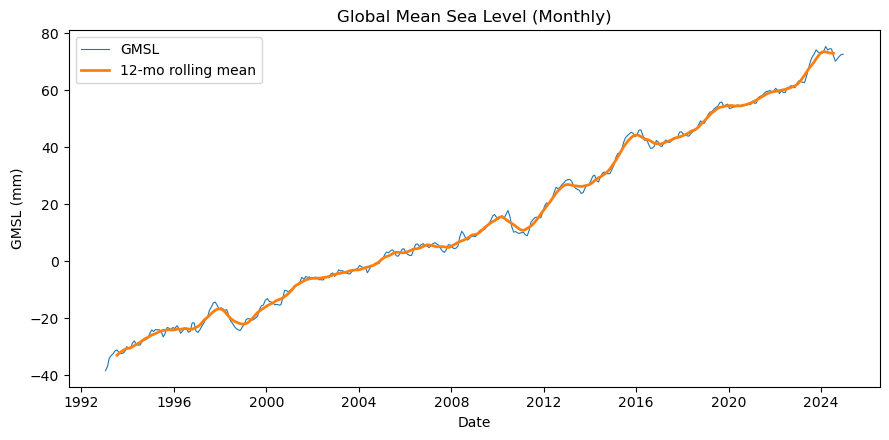

In [85]:
# Fig1: GMSL time series (Panel A) + 12-month rolling mean
fig, ax = plt.subplots(figsize=(9, 4.5))
ax.plot(df_base["date"], df_base["gmsl_mm"], linewidth=0.8, label="GMSL")
roll = df_base.set_index("date")["gmsl_mm"].rolling(12, center=True).mean()
ax.plot(roll.index, roll.values, linewidth=2.0, label="12-mo rolling mean")
ax.set_title("Global Mean Sea Level (Monthly)")
ax.set_xlabel("Date")
ax.set_ylabel("GMSL (mm)")
ax.legend()
fig.tight_layout()
fig.savefig("pic/fig1_gmsl_ts.png", dpi=300)
plt.show()


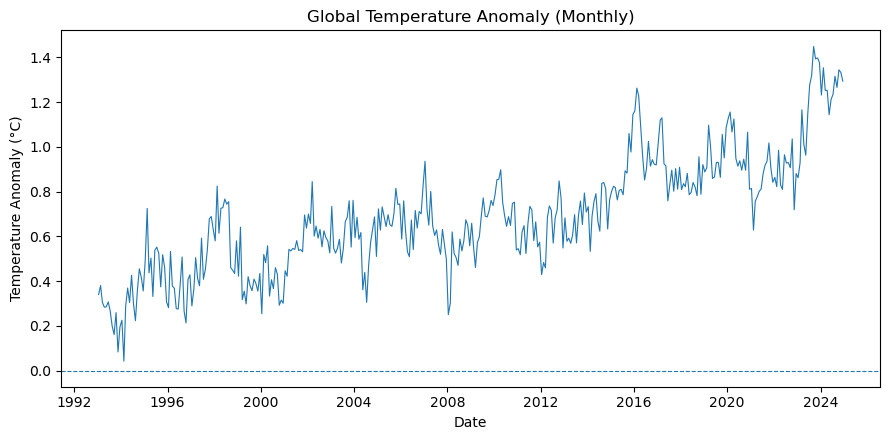

In [86]:
# Fig2: Temperature anomaly time series (Panel A)
fig, ax = plt.subplots(figsize=(9, 4.5))
ax.axhline(0, linestyle="--", linewidth=0.8)
ax.plot(df_base["date"], df_base["temp_anom"], linewidth=0.8)
ax.set_title("Global Temperature Anomaly (Monthly)")
ax.set_xlabel("Date")
ax.set_ylabel("Temperature Anomaly (°C)")
fig.tight_layout()
fig.savefig("pic/fig2_temp_ts.png", dpi=300)
plt.show()


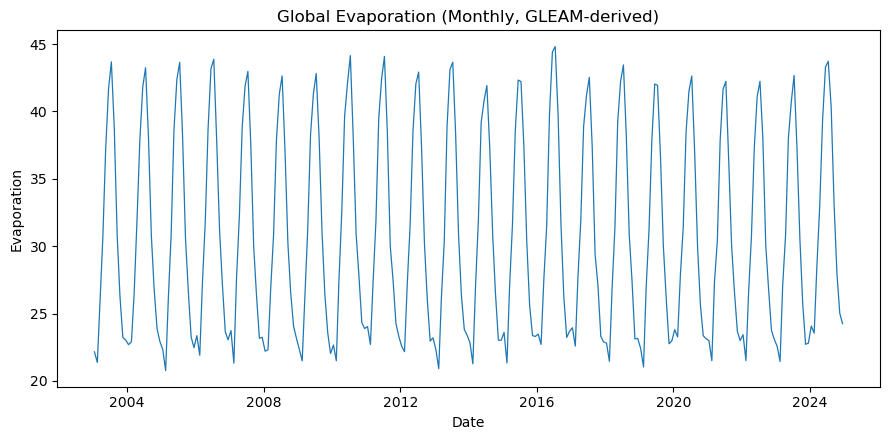

In [87]:
# Fig3: Evaporation time series (Panel B)
fig, ax = plt.subplots(figsize=(9, 4.5))
ax.plot(df_evap["date"], df_evap["evap"], linewidth=0.9)
ax.set_title("Global Evaporation (Monthly, GLEAM-derived)")
ax.set_xlabel("Date")
ax.set_ylabel("Evaporation")
fig.tight_layout()
fig.savefig("pic/fig3_evap_ts.png", dpi=300)
plt.show()


### Fig4: Scatter + fitted line (Panel A)

We fit the simple model:

\[
\text{GMSL}_t = \alpha + \beta \cdot \text{TempAnom}_t + \varepsilon_t.
\]

and annotate the slope (mm/°C).


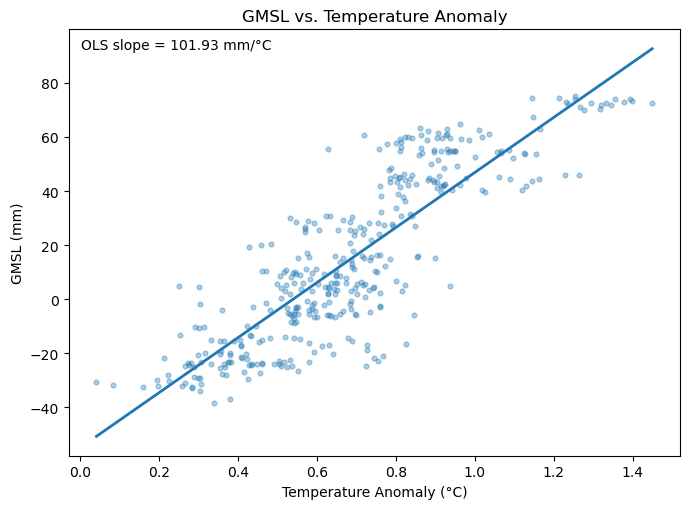

In [88]:
X1 = sm.add_constant(df_base[["temp_anom"]])
m1 = sm.OLS(df_base["gmsl_mm"], X1).fit()
slope = m1.params["temp_anom"]

fig, ax = plt.subplots(figsize=(7, 5.2))
ax.scatter(df_base["temp_anom"], df_base["gmsl_mm"], alpha=0.35, s=12)

xgrid = np.linspace(df_base["temp_anom"].min(), df_base["temp_anom"].max(), 200)
yhat = m1.params["const"] + slope * xgrid
ax.plot(xgrid, yhat, linewidth=2.0)

ax.set_title("GMSL vs. Temperature Anomaly")
ax.set_xlabel("Temperature Anomaly (°C)")
ax.set_ylabel("GMSL (mm)")
ax.text(0.02, 0.98, f"OLS slope = {slope:.2f} mm/°C", transform=ax.transAxes, va="top")

fig.tight_layout()
fig.savefig("pic/fig4_scatter_gmsl_temp.png", dpi=300)
plt.show()


### Fig5: Multi-dimensional bubble plot (Panel A)

- x = temperature anomaly
- y = GMSL
- color = decade
- size = time progression

✅ This satisfies the “≥ 3 variables in one figure” requirement.


/var/folders/t9/fg_z55rj35n5dtjqkbq_zp640000gn/T/ipykernel_4257/1892850518.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("viridis", len(decades))   # 和散点保持一致


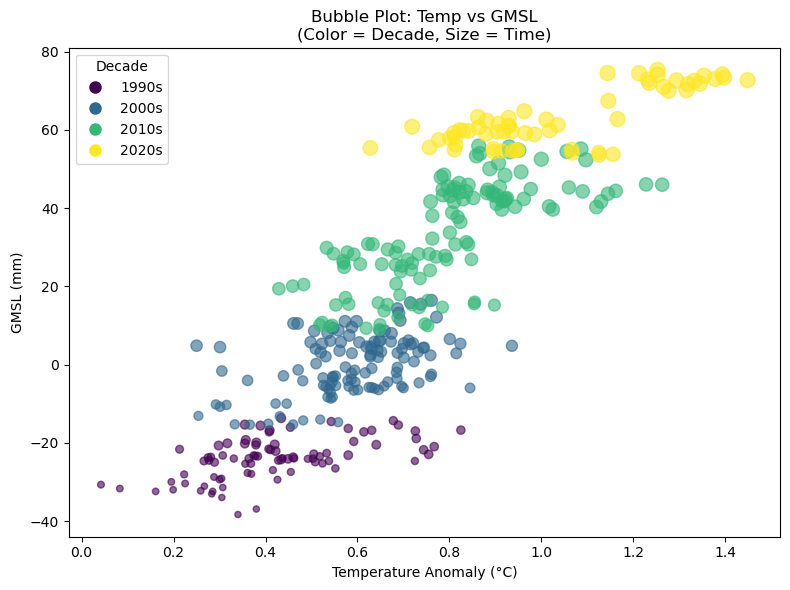

In [89]:
import matplotlib.cm as cm
import matplotlib.colors as colors

decades = sorted(df_base["decade"].unique())
decade_to_int = {d:i for i,d in enumerate(decades)}
cvals = df_base["decade"].map(decade_to_int).values

cmap = cm.get_cmap("viridis", len(decades))   # 和散点保持一致
norm = colors.Normalize(vmin=0, vmax=len(decades)-1)

fig, ax = plt.subplots(figsize=(8, 6))
sc = ax.scatter(df_base["temp_anom"], df_base["gmsl_mm"],
                c=cvals, cmap=cmap, norm=norm,
                s=20*df_base["t_idx"], alpha=0.6)

ax.set_title("Bubble Plot: Temp vs GMSL\n(Color = Decade, Size = Time)")
ax.set_xlabel("Temperature Anomaly (°C)")
ax.set_ylabel("GMSL (mm)")

# ✅ 手动 legend：每个 decade 用对应的颜色
handles = []
for d in decades:
    i = decade_to_int[d]
    color = cmap(norm(i))
    h = plt.Line2D([0],[0], marker="o", linestyle="",
                   markersize=8, label=d,
                   markerfacecolor=color, markeredgecolor=color)
    handles.append(h)

ax.legend(handles=handles, title="Decade", loc="best", frameon=True)

fig.tight_layout()
fig.savefig("pic/fig5_bubble_3vars.png", dpi=300)
plt.show()

## 6) Regressions + HAC (Newey–West, lag = 12) + Hypothesis Testing

*(Including Decade Effects and Interaction Terms)*

We conduct analyses on two samples:

* **Panel A (Long Sample):** Temperature + GMSL (1993–2024)
* **Panel B (Short Sample):** Temperature + GMSL + Evaporation + CO₂
  (Because evaporation data start later, this sample is shorter; all subsequent analyses on **covariate significance, interaction terms, and decade heterogeneity** are based on Panel B.)

**Outputs of this section:**

* Regression tables (OLS and HAC)
* Joint significance of decade effects and interaction terms (Wald tests using HAC covariance matrices)


In [90]:
def ols_with_hac(y: pd.Series, X: pd.DataFrame, lags: int = 12):
    '''
    Fit OLS and attach HAC(Newey-West) standard errors (lag=lags).

    返回：
      - model: statsmodels OLS 拟合结果
      - tab: 系数表（包含 OLS 与 HAC 的 SE / t / p）
      - V_hac: HAC 协方差矩阵（后面做整体 Wald 检验用）
    '''
    Xc = sm.add_constant(X, has_constant="add")
    model = sm.OLS(y, Xc).fit()

    V_hac = cov_hac(model, nlags=lags)
    se_hac = np.sqrt(np.diag(V_hac))

    t_hac = model.params / se_hac
    p_hac = 2 * (1 - _norm_cdf(np.abs(t_hac)))  # asymptotic normal approx

    tab = pd.DataFrame({
        "coef": model.params,
        "SE (OLS)": model.bse,
        "t (OLS)": model.tvalues,
        "p (OLS)": model.pvalues,
        "SE (HAC)": se_hac,
        "t (HAC)": t_hac,
        "p (HAC)": p_hac,
    })
    return model, tab, V_hac

# =========================
# Panel A
# =========================
A1_model, A1_tab, A1_V = ols_with_hac(df_base["gmsl_mm"], df_base[["temp_anom"]], lags=12)
A2_model, A2_tab, A2_V = ols_with_hac(df_base["gmsl_mm"], df_base[["temp_anom", "trend"]], lags=12)

# --------- Result ----------
print("=== Panel A ===")
display(A1_tab.round(4))
display(A2_tab.round(4))

=== Panel A ===


,coef,SE (OLS),t (OLS),p (OLS),SE (HAC),t (HAC),p (HAC)
const,-55.0336,2.2899,-24.0336,0.0,3.5942,-15.3117,0.0
temp_anom,101.9273,3.1160,32.7109,0.0,5.0001,20.3851,0.0


,coef,SE (OLS),t (OLS),p (OLS),SE (HAC),t (HAC),p (HAC)
const,-41.9893,0.5813,-72.2311,0.0,1.7479,-24.0222,0.0
temp_anom,13.5116,1.3636,9.9088,0.0,3.1746,4.2561,0.0
trend,0.2493,0.0032,77.9827,0.0,0.0076,32.8975,0.0


In [91]:
# =========================
# Panel B (Short Sample): Temperature + Sea Level + Evaporation
# All subsequent analyses on covariate significance, decade heterogeneity, and interaction terms** are based on this sample.
# =========================
d = df_evap.copy()

# (B1) 最基础：Temp + Evap
B1_model, B1_tab, B1_V = ols_with_hac(d["gmsl_mm"], d[["temp_anom", "evap", "co2_avg"]], lags=12)

# (B2) + trend（时间趋势）
B2_model, B2_tab, B2_V = ols_with_hac(d["gmsl_mm"], d[["temp_anom", "evap", "co2_avg", "trend"]], lags=12)

# (B3) + 月份哑变量（季节性）
month_dum = pd.get_dummies(d["month"].astype(int), prefix="m", drop_first=True).astype(float)
XB3 = pd.concat([d[["temp_anom", "evap", "co2_avg", "trend"]], month_dum], axis=1)

print(month_dum.dtypes)
print(XB3.dtypes)

B3_model, B3_tab, B3_V = ols_with_hac(d["gmsl_mm"], XB3, lags=12)


# (B4) temp × decade + dummy_month
# decade：D_k
# inter：temp_anom * D_k
decade_str = d["decade"].astype(str)
decade_dum = pd.get_dummies(decade_str, prefix="dec", drop_first=True).astype(float)
inter = decade_dum.mul(d["temp_anom"], axis=0)
inter.columns = [c + "_x_temp" for c in inter.columns]

XB4 = pd.concat(
    [d[["temp_anom", "evap", "co2_avg", "trend"]], month_dum, decade_dum, inter],
    axis=1
)
B4_model, B4_tab, B4_V = ols_with_hac(d["gmsl_mm"], XB4, lags=12)

print("=== Panel B (with evaporation) ===")
display(B1_tab.round(4))
display(B2_tab.round(4))
display(B3_tab.round(4))
display(B4_tab.round(4))

m_2     float64
m_3     float64
m_4     float64
m_5     float64
m_6     float64
m_7     float64
m_8     float64
m_9     float64
m_10    float64
m_11    float64
m_12    float64
dtype: object
temp_anom    float64
evap         float64
co2_avg      float64
trend        float64
m_2          float64
m_3          float64
m_4          float64
m_5          float64
m_6          float64
m_7          float64
m_8          float64
m_9          float64
m_10         float64
m_11         float64
m_12         float64
dtype: object
=== Panel B (with evaporation) ===


,coef,SE (OLS),t (OLS),p (OLS),SE (HAC),t (HAC),p (HAC)
const,-538.7682,8.8996,-60.5383,0.0000,8.6405,-62.3540,0.0000
temp_anom,16.1706,1.6466,9.8203,0.0000,2.1759,7.4315,0.0000
evap,-0.1050,0.0325,-3.2315,0.0014,0.0264,-3.9729,0.0001
co2_avg,1.4040,0.0249,56.3537,0.0000,0.0248,56.6838,0.0000


,coef,SE (OLS),t (OLS),p (OLS),SE (HAC),t (HAC),p (HAC)
const,-133.6247,30.5801,-4.3697,0.0000,51.5687,-2.5912,0.0096
temp_anom,13.9392,1.2712,10.9658,0.0000,2.1368,6.5234,0.0000
evap,-0.0012,0.0260,-0.0469,0.9626,0.0305,-0.0400,0.9681
co2_avg,0.3122,0.0826,3.7815,0.0002,0.1386,2.2522,0.0243
trend,0.2187,0.0161,13.5901,0.0000,0.0287,7.6140,0.0000


,coef,SE (OLS),t (OLS),p (OLS),SE (HAC),t (HAC),p (HAC)
const,-493.9954,77.7351,-6.3549,0.0000,241.5105,-2.0454,0.0408
temp_anom,13.5516,1.3229,10.2438,0.0000,3.0250,4.4799,0.0000
evap,-1.5281,0.2446,-6.2484,0.0000,0.5166,-2.9580,0.0031
co2_avg,1.3707,0.2082,6.5842,0.0000,0.6511,2.1052,0.0353
trend,0.0168,0.0390,0.4308,0.6670,0.1214,0.1384,0.8899
m_2,-2.2825,0.8674,-2.6313,0.0090,0.8300,-2.7499,0.0060
m_3,4.2630,1.2845,3.3188,0.0010,2.1572,1.9762,0.0481
m_4,9.1751,2.2804,4.0234,0.0001,4.4939,2.0417,0.0412
m_5,20.2434,3.9591,5.1131,0.0000,8.2054,2.4671,0.0136
m_6,27.0196,4.7553,5.6821,0.0000,10.0236,2.6956,0.0070


,coef,SE (OLS),t (OLS),p (OLS),SE (HAC),t (HAC),p (HAC)
const,-540.1223,105.8207,-5.1041,0.0000,231.6223,-2.3319,0.0197
temp_anom,8.3458,2.4693,3.3798,0.0008,2.8665,2.9115,0.0036
evap,-1.4571,0.2482,-5.8706,0.0000,0.3779,-3.8555,0.0001
co2_avg,1.4976,0.2842,5.2689,0.0000,0.6173,2.4260,0.0153
trend,0.0011,0.0539,0.0209,0.9833,0.1149,0.0098,0.9922
m_2,-2.3736,0.8648,-2.7448,0.0065,0.5939,-3.9964,0.0001
m_3,3.7002,1.2651,2.9248,0.0038,1.7589,2.1038,0.0354
m_4,8.1391,2.2643,3.5946,0.0004,3.6154,2.2513,0.0244
m_5,18.5778,3.9394,4.7158,0.0000,6.2971,2.9502,0.0032
m_6,25.3081,4.7521,5.3257,0.0000,7.5565,3.3492,0.0008


In [92]:
# ==========================================================
# Hypothesis Testing (Four Categories Reported in the Paper)
# i) Significance of the main regressor (temp_anom): assessed using HAC p-values.
# ii) Significance of the covariate (evap): assessed using HAC p-values.
# iii) Decade heterogeneity:** joint significance of decade main effects, tested via a Wald test with HAC covariance.
# iv) Interaction effects:** joint significance of the temp × decade interaction terms, tested via a Wald test with HAC covariance.
# v) Seasonality: joint significance of monthly dummy variables.
# ==========================================================

def wald_joint_test(param_names, model, V_hac):

    all_params = list(model.params.index)
    names = [nm for nm in param_names if nm in all_params]
    if len(names) == 0:
        return None, names
    R = np.zeros((len(names), len(all_params)))
    for i, nm in enumerate(names):
        R[i, all_params.index(nm)] = 1.0
    return model.wald_test(R, cov_p=V_hac), names

print("\n=== (i) temp_anom（B4, HAC）===")
if "temp_anom" in B4_tab.index:
    print(B4_tab.loc["temp_anom", ["coef", "SE (HAC)", "t (HAC)", "p (HAC)"]])

print("\n=== (ii) evap（B4, HAC）===")
if "evap" in B4_tab.index:
    print(B4_tab.loc["evap", ["coef", "SE (HAC)", "t (HAC)", "p (HAC)"]])

# (iii) 
dec_main = [c for c in XB4.columns if c.startswith("dec_") and (not c.endswith("_x_temp"))]
wald_dec, used_dec = wald_joint_test(dec_main, B4_model, B4_V)
print("\n=== (iii) decade （B4, HAC Wald）===")
print("Used terms:", used_dec[:5], "..." if len(used_dec) > 5 else "")
print(wald_dec if wald_dec is not None else "No decade main-effect terms found.")

# (iv) 
inter_terms = [c for c in XB4.columns if c.endswith("_x_temp")]
wald_inter, used_inter = wald_joint_test(inter_terms, B4_model, B4_V)
print("\n=== (iv)temp × decade（B4, HAC Wald）===")
print("Used terms:", used_inter[:5], "..." if len(used_inter) > 5 else "")
print(wald_inter if wald_inter is not None else "No interaction terms found.")

# (v) 
season_terms = [c for c in XB3.columns if c.startswith("m_")]
wald_season, used_season = wald_joint_test(season_terms, B4_model, B4_V)

print("\n=== (v) seasonality（B3, HAC Wald）===")
print("Used terms:", used_season)
print(wald_season if wald_season is not None else "No seasonal dummy terms found.")



=== (i) temp_anom（B4, HAC）===
coef        8.345775
SE (HAC)    2.866510
t (HAC)     2.911476
p (HAC)     0.003597
Name: temp_anom, dtype: float64

=== (ii) evap（B4, HAC）===
coef       -1.457143
SE (HAC)    0.377937
t (HAC)    -3.855521
p (HAC)     0.000115
Name: evap, dtype: float64

=== (iii) decade （B4, HAC Wald）===
Used terms: ['dec_2010s', 'dec_2020s'] 
<F test: F=array([[1.11566644]]), p=0.3293625870237937, df_denom=244, df_num=2>

=== (iv)temp × decade（B4, HAC Wald）===
Used terms: ['dec_2010s_x_temp', 'dec_2020s_x_temp'] 
<F test: F=array([[1.28163045]]), p=0.2794462383849206, df_denom=244, df_num=2>

=== (v) seasonality（B3, HAC Wald）===
Used terms: ['m_2', 'm_3', 'm_4', 'm_5', 'm_6', 'm_7', 'm_8', 'm_9', 'm_10', 'm_11', 'm_12']
<F test: F=array([[4.28172026]]), p=7.73863416811106e-06, df_denom=244, df_num=11>


/opt/miniconda3/lib/python3.13/site-packages/statsmodels/base/model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(
/opt/miniconda3/lib/python3.13/site-packages/numpy/linalg/_linalg.py:3383: RuntimeWarning: divide by zero encountered in matmul
  return _core_matmul(x1, x2)
/opt/miniconda3/lib/python3.13/site-packages/numpy/linalg/_linalg.py:3383: RuntimeWarning: overflow encountered in matmul
  return _core_matmul(x1, x2)
/opt/miniconda3/lib/python3.13/site-packages/numpy/linalg/_linalg.py:3383: RuntimeWarning: invalid value encountered in matmul
  return _core_matmul(x1, x2)


In [93]:
A1_tab.to_csv("out/reg_A1_temp_hac.csv")
A2_tab.to_csv("out/reg_A2_temp_trend_hac.csv")

B1_tab.to_csv("out/reg_B1_temp_evap_hac.csv")
B2_tab.to_csv("out/reg_B2_temp_evap_trend_hac.csv")
B3_tab.to_csv("out/reg_B3_temp_evap_trend_monthFE_hac.csv")
B4_tab.to_csv("out/reg_B4_tempXdecade_evap_trend_monthFE_hac.csv")

print("Saved regression tables:")
for p in [
    "out/reg_A1_temp_hac.csv",
    "out/reg_A2_temp_trend_hac.csv",
    "out/reg_B1_temp_evap_hac.csv",
    "out/reg_B2_temp_evap_trend_hac.csv",
    "out/reg_B3_temp_evap_trend_monthFE_hac.csv",
    "out/reg_B4_tempXdecade_evap_trend_monthFE_hac.csv",
]:
    print(" -", p)


Saved regression tables:
 - out/reg_A1_temp_hac.csv
 - out/reg_A2_temp_trend_hac.csv
 - out/reg_B1_temp_evap_hac.csv
 - out/reg_B2_temp_evap_trend_hac.csv
 - out/reg_B3_temp_evap_trend_monthFE_hac.csv
 - out/reg_B4_tempXdecade_evap_trend_monthFE_hac.csv


## 7) Key Outputs: Slope Interpretation + Model Diagnostics + Multicollinearity + Ridge Regression (per Rubric)
This section perfors four tasks:
1. Report the estimated slope of `temp_anom` (mm/°C) across different model specifications, for use in interpretation and conclusions.
2. Produce the standard set of regression diagnostic plots (eight figures commonly covered in the lecture notes).
3. Assess multicollinearity using the correlation matrix and Variance Inflation Factors (VIF).
4. Implement Ridge regression as a robustness check: when many dummy variables and interaction terms are included, Ridge regression helps mitigate instability caused by multicollinearity.


In [94]:
# =========================
# 7.1 beta of temp_anom 9mm/°C）
# =========================
def show_temp_slope(name: str, model):
    b = float(model.params["temp_anom"])
    print(f"{name}: temp slope = {b:.3f} mm/°C")

print("=== Temp slope across models ===")
show_temp_slope("A1 (Temp)", A1_model)
show_temp_slope("A2 (Temp + trend)", A2_model)
show_temp_slope("B1 (Temp + evap)", B1_model)
show_temp_slope("B2 (Temp + evap + trend)", B2_model)
show_temp_slope("B3 ( + month FE )", B3_model)
show_temp_slope("B4 ( + decade + interactions )", B4_model)

=== Temp slope across models ===
A1 (Temp): temp slope = 101.927 mm/°C
A2 (Temp + trend): temp slope = 13.512 mm/°C
B1 (Temp + evap): temp slope = 16.171 mm/°C
B2 (Temp + evap + trend): temp slope = 13.939 mm/°C
B3 ( + month FE ): temp slope = 13.552 mm/°C
B4 ( + decade + interactions ): temp slope = 8.346 mm/°C


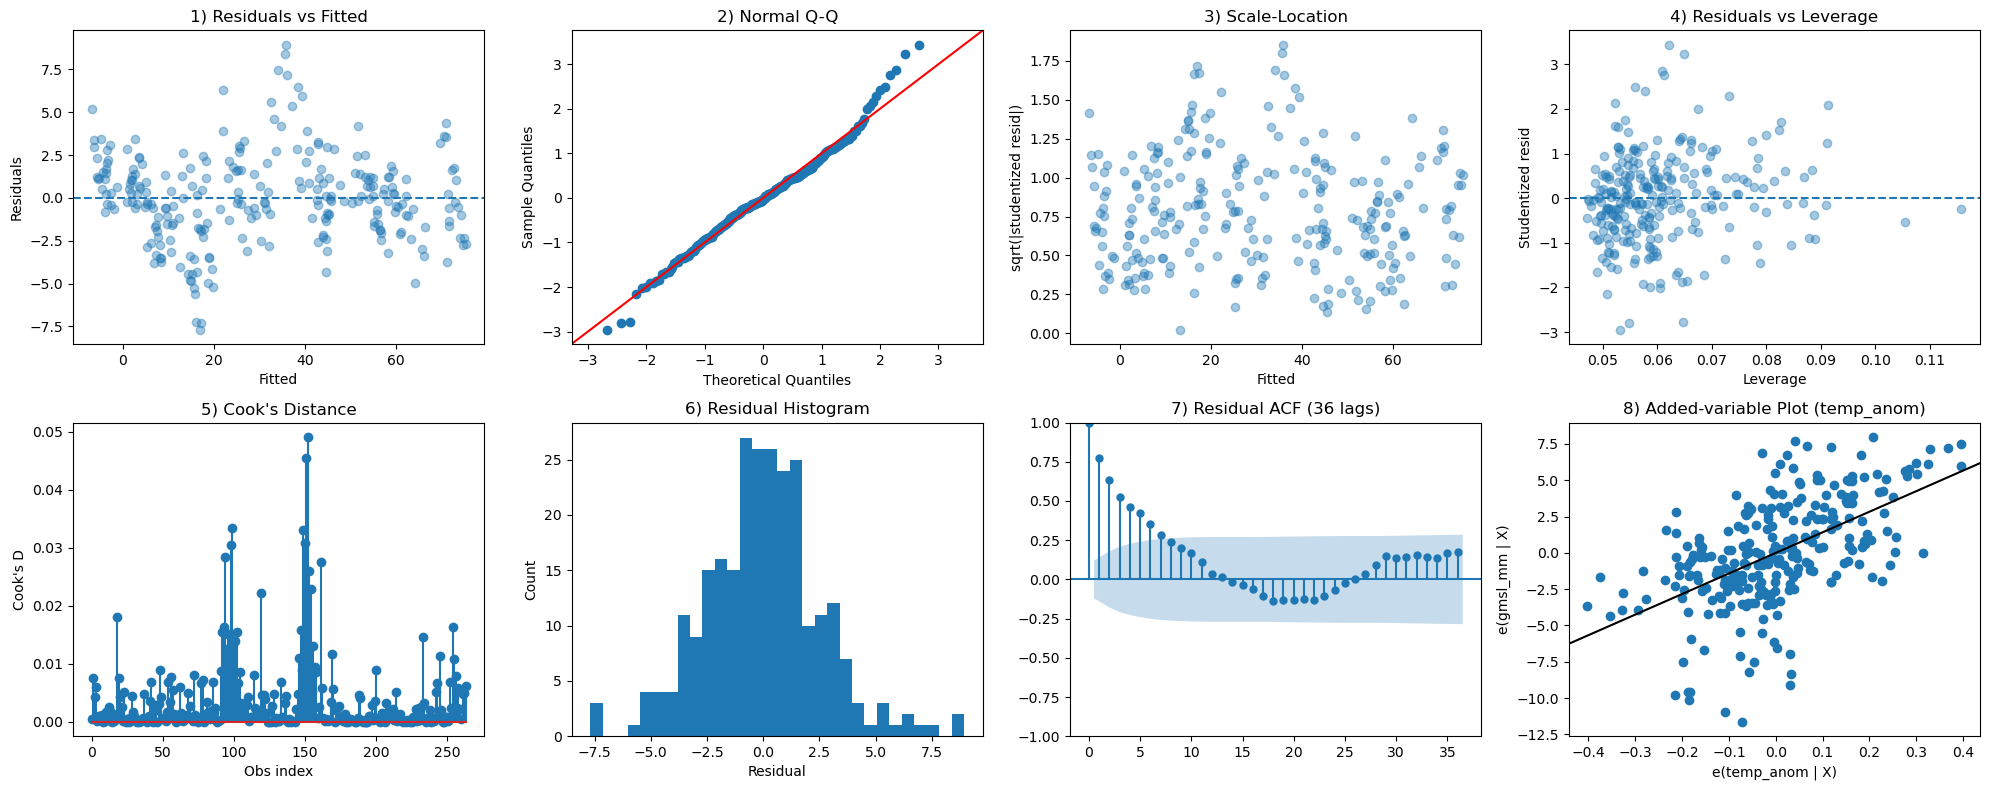

In [95]:
# =========================
# 7.2 model_diag 2*4
# =========================
model_diag = B3_model

fitted = model_diag.fittedvalues
resid  = model_diag.resid

infl = model_diag.get_influence()
std_resid = infl.resid_studentized_internal
leverage = infl.hat_matrix_diag
cooks = infl.cooks_distance[0]

from statsmodels.graphics.gofplots import qqplot
from statsmodels.graphics.tsaplots import plot_acf

fig, axes = plt.subplots(2, 4, figsize=(20, 8))
axes = axes.flatten()  # 方便按 0~7 访问

# 1) Residuals vs Fitted
axes[0].scatter(fitted, resid, alpha=0.4)
axes[0].axhline(0, linestyle="--")
axes[0].set_title("1) Residuals vs Fitted")
axes[0].set_xlabel("Fitted")
axes[0].set_ylabel("Residuals")

# 2) Normal Q-Q
qqplot(resid, line="45", fit=True, ax=axes[1])
axes[1].set_title("2) Normal Q-Q")

# 3) Scale-Location
axes[2].scatter(fitted, np.sqrt(np.abs(std_resid)), alpha=0.4)
axes[2].set_title("3) Scale-Location")
axes[2].set_xlabel("Fitted")
axes[2].set_ylabel("sqrt(|studentized resid|)")

# 4) Residuals vs Leverage
axes[3].scatter(leverage, std_resid, alpha=0.4)
axes[3].axhline(0, linestyle="--")
axes[3].set_title("4) Residuals vs Leverage")
axes[3].set_xlabel("Leverage")
axes[3].set_ylabel("Studentized resid")

# 5) Cook's Distance
axes[4].stem(cooks)
axes[4].set_title("5) Cook's Distance")
axes[4].set_xlabel("Obs index")
axes[4].set_ylabel("Cook's D")

# 6) Residual Histogram
axes[5].hist(resid, bins=30)
axes[5].set_title("6) Residual Histogram")
axes[5].set_xlabel("Residual")
axes[5].set_ylabel("Count")

# 7) Residual ACF
plot_acf(resid, lags=36, ax=axes[6])
axes[6].set_title("7) Residual ACF (36 lags)")

# 8) Added-variable plot（temp_anom）
sm.graphics.plot_partregress(
    "gmsl_mm",
    "temp_anom",
    ["evap", "trend"],
    data=d,
    ax=axes[7],
    obs_labels=False
)
axes[7].set_title("8) Added-variable Plot (temp_anom)")

plt.tight_layout()
plt.show()



=== Correlation matrix (temp_anom, evap, trend) ===


,temp_anom,evap,trend,co2_avg
temp_anom,1.000,-0.059,0.758,0.749
evap,-0.059,1.000,0.006,0.056
trend,0.758,0.006,1.000,0.987
co2_avg,0.749,0.056,0.987,1.000


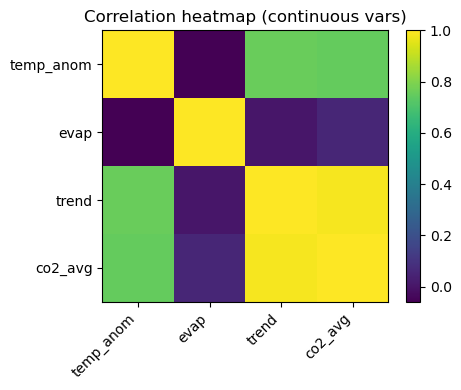


=== VIF table ===


,variable,VIF
0,const,27523.748112
1,temp_anom,2.375293
2,evap,1.123904
3,trend,44.267066
4,co2_avg,43.761532


In [96]:
# =========================
# 7.3 corr + VIF
# =========================
X_cont = d[["temp_anom", "evap", "trend",'co2_avg']].copy()
corr = X_cont.corr()
print("\n=== Correlation matrix (temp_anom, evap, trend) ===")
display(corr.round(3))

plt.figure(figsize=(4.8,4))
plt.imshow(corr.values, aspect="auto")
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45, ha="right")
plt.yticks(range(len(corr.index)), corr.index)
plt.title("Correlation heatmap (continuous vars)")
plt.colorbar()
plt.tight_layout()
plt.show()

from statsmodels.stats.outliers_influence import variance_inflation_factor

X_vif = sm.add_constant(X_cont)
vif_table = pd.DataFrame({
    "variable": X_vif.columns,
    "VIF": [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
})
print("\n=== VIF table ===")
display(vif_table)

In [97]:

# =========================
# 7.4 Ridge
# =========================
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV
from sklearn.metrics import r2_score

feat_num = ["temp_anom", "evap", "co2_avg", "trend"]
feat_cat = ["month", "decade"]

X_r = d[feat_num].copy()
X_r = pd.concat([X_r, pd.get_dummies(d[feat_cat], drop_first=True)], axis=1)
y_r = d["gmsl_mm"].values

num_cols = feat_num
cat_cols = [c for c in X_r.columns if c not in num_cols]

ct = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", "passthrough", cat_cols),
    ],
    remainder="drop",
)

alphas = np.logspace(-3, 3, 50)
ridge = RidgeCV(alphas=alphas, cv=5)

pipe = Pipeline([("prep", ct), ("ridge", ridge)])
pipe.fit(X_r, y_r)

yhat = pipe.predict(X_r)
print("\n=== Ridge Regression ===")
print("Chosen alpha =", pipe.named_steps["ridge"].alpha_)
print("In-sample R^2 =", r2_score(y_r, yhat))

feature_names = pipe.named_steps["prep"].get_feature_names_out()

coef_tab = pd.DataFrame({
    "feature": feature_names,
    "ridge_coef": pipe.named_steps["ridge"].coef_
})

display(coef_tab)



print("\nRidge coef (temp_anom) =",
      float(
    coef_tab.loc[
        coef_tab["feature"] == "num__temp_anom",
        "ridge_coef"
    ]
))



=== Ridge Regression ===
Chosen alpha = 10.985411419875572
In-sample R^2 = 0.9837563711237811


/opt/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/opt/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/opt/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: invalid value encountered in matmul
  return X @ coef_ + self.intercept_


,feature,ridge_coef
0,num__temp_anom,3.424774
1,num__evap,-0.228522
2,num__co2_avg,9.412483
3,num__trend,10.799895
4,cat__month,0.210082
5,cat__decade_2010s,0.199176
6,cat__decade_2020s,1.305103



Ridge coef (temp_anom) = 3.4247740925142445


/var/folders/t9/fg_z55rj35n5dtjqkbq_zp640000gn/T/ipykernel_4257/383160900.py:51: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  float(


In [98]:
import numpy as np
import pandas as pd
from sklearn.utils import resample
from tqdm import trange

B = 500
rng = np.random.default_rng(2024)

coef_list = []
alpha_list = []

n = len(y_r)

for b in trange(B):
    # bootstrap 抽样
    idx = rng.choice(n, size=n, replace=True)
    X_b = X_r.iloc[idx]
    y_b = y_r[idx]

    # 在 bootstrap 样本上重新 fit（含 CV）
    pipe.fit(X_b, y_b)

    # 记录系数 & alpha
    coef_list.append(pipe.named_steps["ridge"].coef_)
    alpha_list.append(pipe.named_steps["ridge"].alpha_)

coef_boot = np.vstack(coef_list)   # shape: (B, p)
feature_names = pipe.named_steps["prep"].get_feature_names_out()

coef_boot_df = pd.DataFrame(
    coef_boot,
    columns=feature_names
)

100%|██████████| 500/500 [00:37<00:00, 13.33it/s]


In [99]:
coef_summary = (
    coef_boot_df
    .agg(["mean", "std"])
    .T
    .rename(columns={"mean": "boot_mean", "std": "boot_sd"})
)

coef_summary["ci_2.5"] = coef_boot_df.quantile(0.025)
coef_summary["ci_97.5"] = coef_boot_df.quantile(0.975)

from IPython.display import display
display(coef_summary)


,boot_mean,boot_sd,ci_2.5,ci_97.5
num__temp_anom,2.869244,0.304258,2.269033,3.432693
num__evap,-0.044060,0.194946,-0.408629,0.339254
num__co2_avg,5.201044,1.705618,1.882714,8.548913
num__trend,17.574374,1.834853,13.960641,20.920204
cat__month,0.069308,0.065891,-0.055876,0.198422
cat__decade_2010s,-3.045535,1.017392,-4.962640,-0.995053
cat__decade_2020s,-3.948968,1.484252,-6.600171,-1.038555


In [100]:
alpha_boot = pd.Series(alpha_list, name="alpha")
display(alpha_boot.describe())

count    500.000000
mean       0.107235
std        0.110624
min        0.001000
25%        0.029471
50%        0.091030
75%        0.159986
max        0.655129
Name: alpha, dtype: float64